In [1]:
from functions import *

# Find stability

### Test on one contour

x-location difference CoM-CoB = -2.71 px


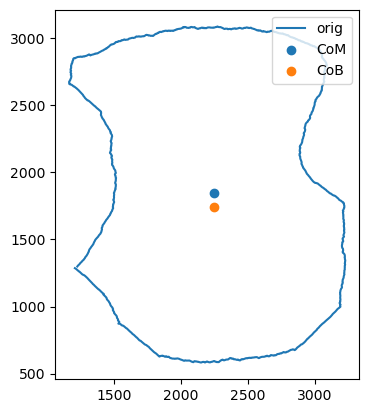

In [ ]:
plt.figure()
contour = np.genfromtxt(contoursPATH[15],dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
shift = (max(contour[:,1])-min(contour[:,1]))*4/3
contour[:,1 ] = -contour[:,1] + shift 

plt.plot(contour[:,0],contour[:,1],label='orig')



com,cob = hydrostasy(contour)

plt.scatter(com.x,com.y,label='CoM')
plt.scatter(cob.x,cob.y,label='CoB')
print(f'x-location difference CoM-CoB = {com.x-cob.x:.2f} px')

plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
plt.show()

### Check rotations of contour

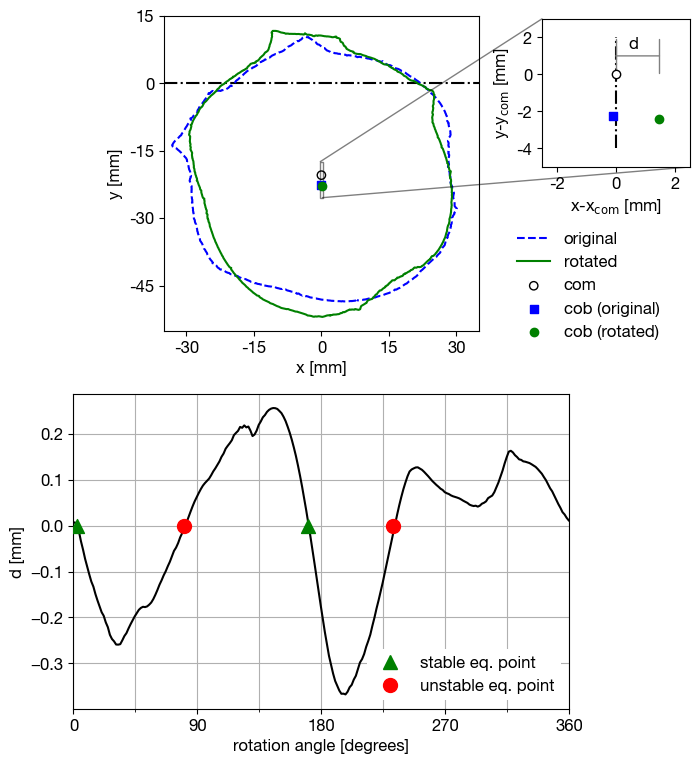

In [62]:
area_px = 1694812 # done with fiji
area_m = np.pi*0.0405**2
calibration = np.sqrt(area_px/area_m) #px/m

frame = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0115.csv'
contour = np.genfromtxt(frame,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
wl = findWL(contour)
contour[:,1]-=wl
com,_ = hydrostasy(contour)
contour[:,0] = (contour[:,0] - com.x)

fig,axs = plt.subplots(nrows=2,ncols=1,figsize=(6.4,9))
axs[0].hlines(0.,-0.035,0.035,colors='k',linestyles='-.')
rotAngle = 60
com,cob = hydrostasy(contour,densityRatio=917/1005)
initialCoB = [cob.x,cob.y]
rotatedCont = rotate(contour,[com.x,com.y],rotAngle)
axs[0].plot(contour[:,0],contour[:,1],color='blue',label='original',linestyle='dashed')
axs[0].plot(rotatedCont[:,0],rotatedCont[:,1],color='green',label='rotated')
axs[0].scatter(com.x,com.y,marker='o',facecolor='none',edgecolor='k',zorder=100,label='com')
axs[0].scatter(initialCoB[0],initialCoB[1],color='blue',marker='s',zorder=100,label='cob (original)')

del com

com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
axs[0].scatter(cob.x,cob.y,color='green',zorder=100,label='cob (rotated)')

# inset axes....
x1, x2, y1, y2 = -0.0002, +0.0003, -0.004+com.y, +0.0015+com.y # subregion of the original image
axins = axs[0].inset_axes(
    [1.2, 0.52, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2))
axins.scatter(com.x,com.y,marker='o',facecolor='w',edgecolor='k',zorder=100)
axins.scatter(initialCoB[0],initialCoB[1],label='CoB',color='blue',marker='s',zorder=100)
axins.scatter(cob.x,cob.y,color='green',zorder=100)
axins.annotate(text='', xy=(cob.x+1e-5,com.y+10e-4), xytext=(com.x-1e-5,com.y+10e-4), 
               arrowprops=dict(arrowstyle='|-|',color='Grey',))
axins.text(x=cob.x/2-3e-5,y=com.y+14e-4,s=r'd')
axins.vlines(com.x,com.y-.004,com.y+.002,colors='k',linestyle='-.')

axins.set(xlabel=r'x-x$_\text{com}$ [mm]',ylabel=r'y-y$_\text{com}$ [mm]',
          yticks=com.y+np.array([-.004,-.002,0.,.002]),yticklabels=[-4,-2,0,2],
          xticks=np.array([-.0002,0.,.0002,]),xticklabels=[-2,0,2],
          ylim=com.y+np.array((-.005,.003)),xlim=(-.00025,.00025))
axs[0].indicate_inset_zoom(axins, edgecolor="black")
axs[0].legend(loc=(1.1,-.05),frameon=False)
axs[0].set(xlim=(-0.035,0.035),ylim=(-0.055,0.015),
       aspect='equal',
       xlabel='x [mm]',ylabel='y [mm]',
       yticks=[-.045,-.03,-.015,0.,.015,],yticklabels=[-45,-30,-15,0,15,],
       xticks=[-.03,-.015,0.,.015,.030],xticklabels=[-30,-15,0,15,30])

# second figure
angleStep = 1.5
stability = np.zeros((int(360/angleStep),2))

for i,angle in enumerate(np.arange(1,360,angleStep)):
    com,_ = hydrostasy(contour,densityRatio=917/1005)
    rotatedCont = rotate(contour,[com.x,com.y],angle)
    del com
    com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)
    stability[i] = angle, (com.x-cob.x)*1000

axs[1].plot(stability[:,0],stability[:,1],c='k')
zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
index_zc = stability[zero_crossings,0]
unstablePointsAngles = []
for i in zero_crossings:
    if np.gradient(stability[:,1])[i]<0:
        plt.scatter(stability[i,0],0,
                    edgecolors='green',facecolors='green',
                    marker='^',zorder=100,s=100)
    else:
        plt.scatter(stability[i,0],0,
                    edgecolors='red',facecolors='red',
                    marker='o',zorder=100,s=100)
        unstablePointsAngles.append(stability[i,0])

axs[1].set(ylabel='d [mm]',
           xlabel='rotation angle [degrees]',
           xticks=[0,90,180,270,360],xticklabels=[0,90,180,270,360],
           xlim=(0,360))
axs[1].set_xticks([45,135,225,315], minor=True)
axs[1].grid(which='both')

# create manual symbols for legend
handles, labels = axs[1].get_legend_handles_labels()
point0 = Line2D([0], [0], label='stable eq. point', marker='^', markersize=10, 
         markeredgecolor='green', markerfacecolor='green', linestyle='')
point1 = Line2D([0], [0], label='unstable eq. point', marker='o', markersize=10, 
         markeredgecolor='red', markerfacecolor='red', linestyle='')
handles.extend([point0,point1])
axs[1].legend(handles=handles,loc='lower right',frameon=True,fancybox=False,edgecolor='none',framealpha=1)

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/stabilityIndex.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Apply to all contours

20.9 5.12e+07
19.0 1.71e+08
19.3 6.91e+08


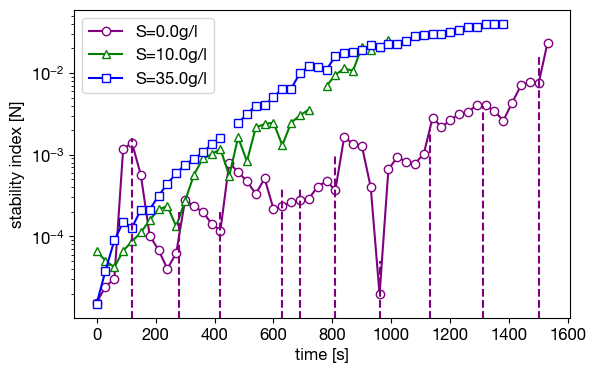

In [2]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-20/1st','2023-09-26/1st','2023-10-03/1st']

plt.figure(figsize=(6.4,4))

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    print(exp_wt,f'{Ra_salinity(exp_radius,0,exp_wt,exp_sal):.2e}')

    radii = []
    xs = []
    ys = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour /= conversion
        area = PolyArea(contour[:,1],contour[:,0]) # m2
        buoyancy = area*917*g # N/m
        
        angleStep = 1.5
        stability = np.zeros((int(360/angleStep),2))

        for i,angle in enumerate(np.arange(1,360,angleStep)):
            com,_ = hydrostasy(contour) ### CHANGE SALTY OR FRESH
            rotatedCont = rotate(contour,[com.x,com.y],angle)
            del com
            com,cob = hydrostasy(rotatedCont)  ### CHANGE SALTY OR FRESH
            stability[i] = angle, com.x-cob.x

        zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
        index_zc = stability[zero_crossings,0]
        unstablePointsAngles = []
        for i in zero_crossings:
            if np.gradient(stability[:,1])[i]>0:
                unstablePointsAngles.append(stability[i,0])

        kwargs_ = [['o','purple'],
                  ['^','green'],
                  ['s','blue']]

        xs.append(30*it)
        ys.append(min(360-unstablePointsAngles[-1],+unstablePointsAngles[0])*max(abs(stability[:,1]))/buoyancy)
    if exp_sal==35.: ys[15]=np.nan # outlier removal
    if exp_sal==10.: ys[25]=np.nan # outlier removal
    plt.plot(xs,ys,marker=kwargs_[ic][0],
                        c=kwargs_[ic][1],mec=kwargs_[ic][1],mfc='white',
                        label=f'S={info[1,0]}g/l')
        
# draw rotation lines
line_heights = [2.8,3.7,3.7,3.4,3.4,3,4.3,2.7,2.4,1.8]
for it,t in enumerate([12,28,42,63,69,81,96,113,131,150]): # rotation times of 09/20/1st
   plt.vlines(t*10,0,10**(-line_heights[it]),colors='purple',linestyles='dashed')

plt.ylabel('stability index [N]',)
plt.xlabel('time [s]',)
plt.gca().tick_params(axis='x', )
plt.gca().tick_params(axis='y', )
plt.legend()
plt.yscale('log')
# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/stability.pdf',format='pdf',bbox_inches='tight')
plt.show()


# Sandbox

2.64459148595217


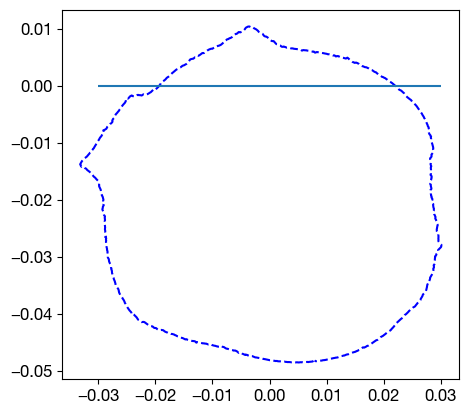

In [33]:
area_px = 1694812 # done with fiji
area_m = np.pi*0.0405**2
calibration = np.sqrt(area_px/area_m) #px/m

frame = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0115.csv'
contour = np.genfromtxt(frame,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
wl = findWL(contour)
com,_ = hydrostasy(contour)
contour[:,1] -= wl
contour[:,0] -= com.x

fig,ax = plt.subplots()
energy = 0.
for point in contour:
    if point[1]>0:continue
    energy += point[1]**2
print(energy)
ax.plot(contour[:,0],contour[:,1],color='blue',label='original',linestyle='dashed')
ax.hlines(0.,-.03,.03)
ax.set(aspect='equal')
plt.show()

0it [00:00, ?it/s]

359it [00:01, 309.75it/s]


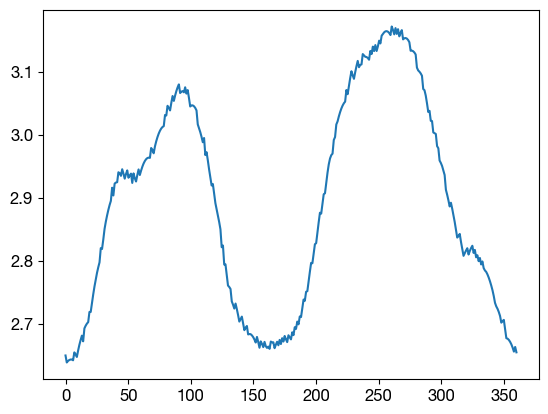

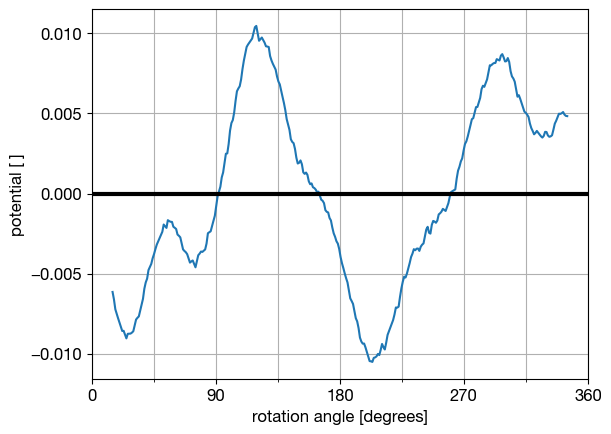

In [63]:
from tqdm import tqdm
area_px = 1694812 # done with fiji
area_m = np.pi*0.0405**2
calibration = np.sqrt(area_px/area_m) #px/m

frame = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/1st_videos/rotation_05/full_contours/0115.csv'
contour = np.genfromtxt(frame,dtype='float',delimiter=',')
if contour.shape[1]!=2: contour = contour.T
contour = contour/calibration
wl = findWL(contour)
com,_ = hydrostasy(contour)
contour[:,1] -= wl
contour[:,0] -= com.x


angleStep = 1
energies = []
for i,angle in tqdm(enumerate(np.arange(1,360,angleStep))):
    com,_ = hydrostasy(contour,densityRatio=917/1005)
    rotatedCont = rotate(contour,[com.x,com.y],angle)
    wl_rotated = findWL(rotatedCont)
    energy = 0.
    for point in rotatedCont:
        if point[1]>0:continue
        energy += (point[1]-wl_rotated)**2
    energies.append(energy)
plt.plot(np.linspace(0,360,len(energies)),energies)
plt.show()
fig,ax=plt.subplots()
N=30
ax.plot(np.linspace(0+N/2,360-N/2,len(energies)-N+1),-np.gradient(running_mean(energies,N)))
ax.set(ylabel='potential [ ]',
           xlabel='rotation angle [degrees]',
           xticks=[0,90,180,270,360],xticklabels=[0,90,180,270,360],
           xlim=(0,360))
ax.set_xticks([45,135,225,315], minor=True)
ax.grid(which='both')
ax.hlines(0,0,360,linewidth=3,colors='k')
plt.show()

In [4]:
Ra(0.0405,0.,19.3)/4e7

1.0456956550554324